In [21]:
# Neural network is still a bigram character language model, outputs the probabaility distribution and make the guesses for what is likely to follow that character
# Gradient based optimisation can tune the parameters of this network

import torch
import matplotlib.pyplot as plt

In [4]:
words = open("names.txt", "r").read().splitlines()

characters = sorted(list(set("".join(words)))) # - throw out duplicates of the lowercase characters and it should return the values correctly
# If we simply use a set within a string or something else we will get all unique possible characters that could be within it
stoi = {s:i+1 for i, s in enumerate(characters)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [34]:
xs, ys = [], []

# Training set
for word in words[:1]:
    # in a bigram we can define how it starts and ends
    # bigrams can be done by counting how often these words appear after another
    chs = ["."] + list(word) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        prior_index = stoi[ch1]
        post_index = stoi[ch2]
        # print(ch1, ch2)
        xs.append(prior_index)
        ys.append(post_index)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [35]:
# torch.Tensor and torch.tensor are both possible ways to do it but we should be very careful
# tensor will infer the data type
# Tensor will normally just keep it to float32 and will always be float32

"""xs = torch.Tensor(xs)
ys = torch.Tensor(ys)

xs = torch.tensor(xs)
ys = torch.tensor(ys)"""

'xs = torch.Tensor(xs)\nys = torch.Tensor(ys)\n\nxs = torch.tensor(xs)\nys = torch.tensor(ys)'

torch.Size([5, 27])


torch.Size([5, 27])

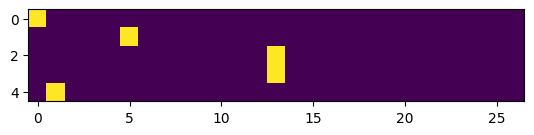

In [36]:
# plugging in indexes into the neural network does not make sense but we can use onehot encoding
import torch.nn.functional as F

# It is far better to not allow it to guess the values, we are far better off specifying how many total classes there are
x_encoding = F.one_hot(xs, num_classes=27).float()
print(x_encoding.shape)

plt.imshow(x_encoding)
x_encoding.shape

In [37]:
# After applying one hot encoding we have to be careful since this wil lreturn us integers but we need floats to be returned
x_encoding.dtype

torch.float32

In [47]:
"""# Fills a tensor with random numbers drawn from a standard normal distribution
# the shape here being 27, 1 indicates th at we have 27 weights conneced to the inputs from 1 neuron
# which will give an output from all 27 inputs
# However we can use far more thatn just one neuron 
W = torch.randn((27, 27))
# If we use the @ operator we do the matrix multiplication and we multiply them
# print(x_encoding.shape)
# print(W.shape)
# Their shapes have the matching 27 values

# This is the most simple neural net that does not even have a non linearity or a bias
# we are simply just trying to produce a probability distribution here and we are essentially keeping
# 27x27 for all possible character combinations
# We have evaluated simultaneously the 5 inputs into the neurons and evaluated them using the input weights
matrix_multiplication = x_encoding @ W 

# Now if we use 27 neurons with 27 input weights each we get a 5 x 27 since we have 5 different bigrams
# and for each we applied the weights to 27 neurons now we have all their outputs

# Exponentiated outputs allows us to interpret an equivalent of counts they are positive numbers
# they can take on various log count values based on the weights
# We are interpreting the weights learned to be the log of counts - they are called logits
# log of counts is the logits, equivalent to the N matrix but with each value with log aplied
counts = matrix_multiplication.exp()

# By exponentiating what we are assumming to be the log of counts we just get teh counts and thus should be equal to N
# Now we have an output from the neural network that was the logits that are exponentiated to get counts
# and these counts are then noramlised meaning that we have probabilities

# Taking the logits and summing them after exponentation is jsut softmax
probabilities = counts / counts.sum(1, keepdims=True)

# Because all of these are differentiable we can backpropagate and optimise the values"""

torch.Size([5, 27])
torch.Size([27, 27])


In [60]:
# During this forward path we are creating this full computational graph that will be used for our .backward()
W = torch.randn((27, 27), requires_grad=True)

# Forward pass for the model
x_encoding = F.one_hot(xs, num_classes=27).float()
logits = x_encoding @ W
counts = logits.exp()

# Probabilities using softmax
probs = counts / counts.sum(1, keepdim=True)


In [93]:
# Loss Calculation
# torch.arange(5) # This will allow us to index our dataset correctly by taking the ith value and then using the ys (actual) for hte loss function
# So because we are using essentially one hot encoding and we are taking the value that has one on it
# we take the ys value and we want to maximise that - the value that is part of the ys index will be the one we care about
# that will affect our loss
loss = -probs[torch.arange(5), ys].log().mean()
loss

tensor(3.0928, grad_fn=<NegBackward0>)

In [94]:
# Backward pass
# None is the lack of a gradient and thus is equal to 0
# After we set our gradient values to 0 and we do .backward() which will calculate all the derivatives according to our value
# we have to make sure to set requires_grad = True (for optimisation reasons)
W.grad = None 
# Make sure we have requires_grad 
loss.backward()

In [95]:
# If we have a positive gradient then increasing it will give us an increase in loss so we want
# to make sure that we go in the negative direction of optimising it
W.grad
W.shape

torch.Size([27, 27])

In [96]:
# Pytorch tensor is now updated
W.data += 0.2 * -W.grad

In [111]:
# During this forward path we are creating this full computational graph that will be used for our .backward()
W = torch.randn((27, 27), requires_grad=True)

# Gradient Descent iterations
for k in range(100):
    # Forward pass for the model
    x_encoding = F.one_hot(xs, num_classes=27).float()
    logits = x_encoding @ W
    counts = logits.exp()

    # Probabilities using softmax
    probs = counts / counts.sum(1, keepdim=True)

    # Loss function
    loss = -probs[torch.arange(5), ys].log().mean()

    W.grad = None
    # Make sure we have requires_grad 
    loss.backward()
    W.data += 0.05 * -W.grad

loss

tensor(2.7798, grad_fn=<NegBackward0>)

In [114]:
# When we incentivise w to be near 0 the probabilities will all go to near 1 and thus is essentially the same as smoothing
# Regularisation allows us to augment the loss function, we can take W**2 and sum those entries
# because we are **2 there are no more signs, 0 loss if W is 0 any non 0 numbers loss is accummulated
# This incentivises us to have weights close to 0 and thus forces a majority of them

# Trying ot make all probabilities correct but also all Ws 0, we are minimising this regularisation loss
# Adds a weight of W being close to 0 and thus this affects the amount of counts by making them non 0
# the more we dominate using our  regularisation constant the more our weights are not allowed to grow
# if we have a strong enough regularisation constant they will all be uniform predictions
# Hence regularisation provides smoothing
probs

tensor([[0.0311, 0.0430, 0.0018, 0.0065, 0.0664, 0.0722, 0.0310, 0.0696, 0.0269,
         0.0404, 0.0023, 0.0630, 0.0212, 0.0073, 0.0062, 0.0168, 0.0827, 0.0176,
         0.0430, 0.0209, 0.0198, 0.0256, 0.0543, 0.0191, 0.1379, 0.0070, 0.0661],
        [0.0205, 0.0572, 0.0120, 0.1230, 0.0421, 0.0592, 0.0407, 0.0983, 0.0065,
         0.0219, 0.0598, 0.0179, 0.0545, 0.0308, 0.0530, 0.0094, 0.0295, 0.0196,
         0.0992, 0.0374, 0.0095, 0.0066, 0.0224, 0.0232, 0.0277, 0.0144, 0.0039],
        [0.0327, 0.0254, 0.0200, 0.0225, 0.0168, 0.0097, 0.0222, 0.0701, 0.0086,
         0.0217, 0.1622, 0.0049, 0.0158, 0.1530, 0.0111, 0.0244, 0.0018, 0.0284,
         0.0101, 0.0044, 0.0052, 0.0132, 0.0431, 0.0080, 0.0376, 0.2173, 0.0095],
        [0.0327, 0.0254, 0.0200, 0.0225, 0.0168, 0.0097, 0.0222, 0.0701, 0.0086,
         0.0217, 0.1622, 0.0049, 0.0158, 0.1530, 0.0111, 0.0244, 0.0018, 0.0284,
         0.0101, 0.0044, 0.0052, 0.0132, 0.0431, 0.0080, 0.0376, 0.2173, 0.0095],
        [0.1064, 0.0334,

In [116]:
g = torch.Generator().manual_seed(2147483647)

index = 0
for i in range(5):
    # number betwen 0 and 1 that are sampled now we can normalise them and use torch.multinomial which will take the probaiility distribution, replacement means that when we draw an element we can put it back into them
    # replacement is by default false within this generator
    index = torch.multinomial(probs[index], num_samples = 1, replacement=True, generator=g).item()
    

10